**Image Retrieval with FAISS and DaViT**

This project demonstrates an image retrieval system using the DaViT model for generating image embeddings and FAISS for efficient similarity search. The goal is to find visually similar images from a dataset based on a query image.

In [1]:
from PIL import Image
import timm
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import faiss
import numpy as np
import glob
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import time

Use the DaViT image classification model trained on ImageNet to create embeddings.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    'davit_base.msft_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

model = model.to(device)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

img = Image.open('i.webp')
output = model(transforms(img).unsqueeze(0).to(device)) # output is (batch_size, num_features) shaped tensor
print(output.shape) 

torch.Size([1, 1024])


DataLoader for uploading images to the model

In [3]:
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = glob.glob(os.path.join(root_dir, '*'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
        

image_folder = 'imagenet/train' 
batch_size = 64

image_dataset = ImageFolderDataset(root_dir=image_folder, transform=transforms)
dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=False) 

Using a Trainable FAISS Index for Efficient Search

In [4]:
index_path = "trained_faiss_index.faissindex"
nlist = 100

embedding_dim = model.num_features

# Initialize FAISS index for cosine similarity search
index = faiss.IndexIVFFlat(faiss.IndexFlatIP(embedding_dim), embedding_dim, nlist, faiss.METRIC_INNER_PRODUCT) 

In [ ]:
pbar = tqdm(dataloader, desc="Processing batches", unit="batch")

all_embeddings_list = [] 

for i, batch in enumerate(pbar):
    batch = batch.to(device)
    with torch.no_grad():
        embeddings = model(batch)
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        embeddings_np = embeddings.cpu().numpy()
        
        all_embeddings_list.append(embeddings_np)

train_data  = np.vstack(all_embeddings_list)

index.train(train_data) # Train the FAISS index on the dataset embeddings

index.add(train_data) # Add embeddings to the trained index

faiss.write_index(index, index_path)


In [5]:
def get_image_embedding(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        print("The image has been opened successfully.")
    except Exception as e:
        print(f"Error opening image: {e}")
    img_tensor = transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(img_tensor)
        embedding = torch.nn.functional.normalize(embedding, p=2, dim=1) # all embeddings  are normalized to unit length (L2 norm = 1).
    return embedding.cpu().numpy().astype('float32')


def find_and_display_nearest_images(image_path, image_embedding, index, image_folder='imagenet/train', k=4):

    image_paths = glob.glob(os.path.join(image_folder, '*'))
    
    # Search for k nearest neighbors
    distances, indices = index.search(image_embedding, k)
    
    # Get paths to nearest images
    nearest_image_paths = [image_paths[i] for i in indices[0]]
    
    # Display images
    plt.figure(figsize=(12, 3))
    plt.subplot(1, k + 1, 1)
    plt.imshow(Image.open(image_path).convert('RGB'))
    plt.title("Query Image")
    plt.axis('off')
    
    for i, (path, distance) in enumerate(zip(nearest_image_paths, distances[0])):
        plt.subplot(1, k + 1, i + 2)
        plt.imshow(Image.open(path).convert('RGB'))
        plt.title(f"Match {i+1}\nDist: {distance:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()



Measuring Search Time with Trained FAISS Index

In [36]:
image_path = 'ship.webp'
k = 10
image_1_embedding = get_image_embedding(image_path)
index = faiss.read_index(index_path)
index.nprobe = 10

num_runs = 1000
times = []


for _ in range(num_runs):
    start = time.time()
    distances, indices = index.search(image_1_embedding, k)
    times.append(time.time() - start)

print(f"Average execution time: {sum(times) / num_runs:.6f} seconds")

The image has been opened successfully.
Average execution time: 0.000084 seconds


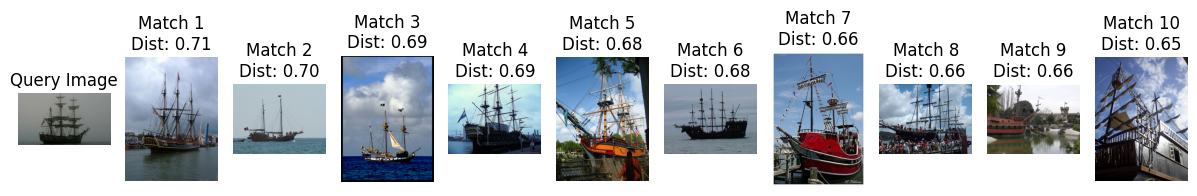

In [37]:
find_and_display_nearest_images(image_path, image_1_embedding, index, image_folder, k)

Using a Non-Trainable FAISS Index

In [38]:
index_path = "faiss_index.faissindex"

index = faiss.IndexFlatIP(embedding_dim)

In [ ]:
pbar = tqdm(dataloader, desc="Processing batches", unit="batch")
all_embeddings_list = [] 

for i, batch in enumerate(pbar):
    batch = batch.to(device)
    with torch.no_grad():
        embeddings = model(batch)
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        embeddings_np = embeddings.cpu().numpy()
        all_embeddings_list.append(embeddings_np)

train_data = np.vstack(all_embeddings_list)

index.add(train_data)

faiss.write_index(index, index_path)

Measuring Search Time with Non-Trainable FAISS Index

In [41]:
index = faiss.read_index(index_path)
query_image_path = 'ship.webp'
query_embedding = get_image_embedding(query_image_path)

num_runs = 1000  
times = []

for _ in range(num_runs):
    start = time.time()
    distances, indices = index.search(image_1_embedding, k)
    times.append(time.time() - start)


print(f"Average execution time: {sum(times) / num_runs:.6f} seconds")

The image has been opened successfully.
Average execution time: 0.006499 seconds


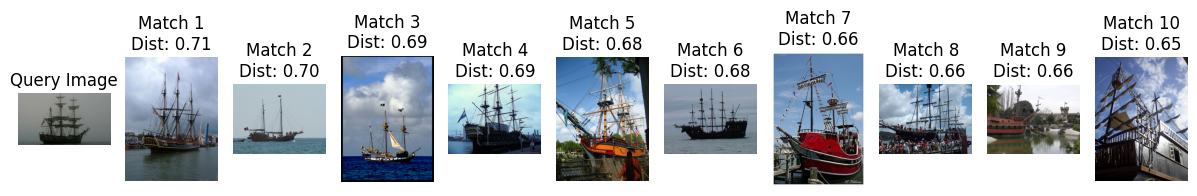

In [42]:
find_and_display_nearest_images(query_image_path, query_embedding, index, image_folder, k)

The trained FAISS index (IVFFlat) demonstrates a significant performance improvement, achieving nearly 77 times faster search times compared to a non-trained index, while maintaining similar retrieval accuracy. 0.000084 vs 0.006499